In [1]:
# loading latent data
import numpy as np
import matplotlib.pyplot as plt

latent_data = np.load('Latent data/latentdata.npy')
labels = np.load('Latent data/simlabels.npy')

In [8]:
latent_data.shape

(63110, 16)

In [9]:
# count the number of each label
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 7445,
 1.0: 19354,
 2.0: 12220,
 3.0: 1900,
 4.0: 1982,
 5.0: 12821,
 6.0: 7361,
 7.0: 14,
 8.0: 8,
 9.0: 5}

In [10]:
import numpy as np
labels_vectors = np.zeros((len(labels), 10))
for i in range(len(labels)):
    labels_vectors[i][int(labels[i])] = 1
np.save('Latent data/labels_vectors.npy', labels_vectors)

In [11]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(latent_data, labels_vectors, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [12]:
device = torch.device("mps")

In [13]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16, 10)
        self.fc2 = nn.Linear(10, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [17]:
# Training loop
num_epochs = 300
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)


    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')

torch.Size([200, 16]) 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  nonzero_finite_vals = torch.masked_select(


tensor([[ -1.2178,   2.3340,   3.7755,  ...,  -5.8559, -19.3967,  -6.2894],
        [ -1.4960,  -2.3795,  -1.1122,  ..., -14.4822, -17.8028, -11.2683],
        [ -0.0996,   2.6420,   3.7142,  ...,  -4.9386,  -6.6519,  -3.7270],
        ...,
        [  2.3629,   2.5882,   2.0842,  ...,  -4.1955,  -4.4634,  -2.9495],
        [  2.0828,   2.3011,   1.1612,  ...,  -6.7432,  -8.1608,  -5.2056],
        [ -1.4151,  -0.6347,   0.9229,  ...,  -7.4498, -10.2665,  -6.5241]],
       device='mps:0', grad_fn=<LinearBackward0>) tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
torch.Size([200, 16]) tensor([[ -4.0781,  -5.4207,  -3.8296,  ..., -12.8617, -21.2554, -13.4637],
        [ -0.3333,   1.0118,   3.4123,  ...,  -7.2162, -17.9190,  -6.9646],
        [ -4.6290,  -0.7384,   5.325

KeyboardInterrupt: 

(0.9, 1.5)

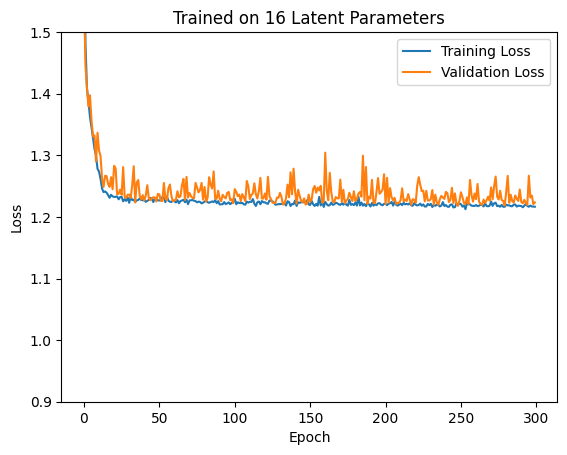

In [236]:
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Trained on 16 Latent Parameters')
plt.ylim(0.9, 1.5)

In [218]:
# test model accuracy
# model = torch.load('simmodel.pth')
model.eval()
test_outputs = model(torch.tensor(X_test).to(device))


In [219]:
test_outputs_categorical = np.zeros(test_outputs.shape)
for i in range(len(test_outputs)):
    _, indices = torch.max(test_outputs[i], 0)    
    predicted_label = indices.item()
    test_outputs_categorical[i][predicted_label] = 1

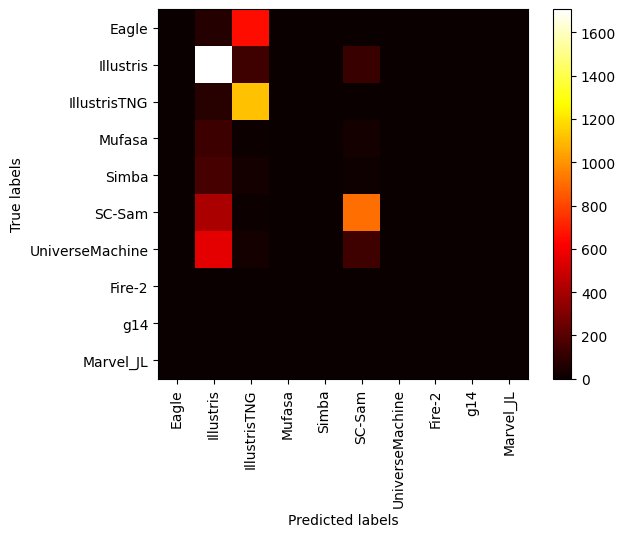

In [225]:
confusion_matrix = np.zeros((10, 10))
for i in range(len(y_test)):
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(test_outputs_categorical[i])
    confusion_matrix[true_label][predicted_label] += 1

plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
# Labelling the simulation names

sim_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
plt.xticks(np.arange(10), sim_names, rotation=90)
plt.yticks(np.arange(10), sim_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.colorbar()

In [221]:
# Printing the confusion matrix without scientific notation
np.set_printoptions(suppress=True)
print(confusion_matrix)

[[   0.   69.  658.    0.    0.    4.    0.    0.    0.    0.]
 [   0. 1708.  135.    0.    0.  125.    0.    0.    0.    0.]
 [   0.   76. 1116.    0.    0.    1.    0.    0.    0.    0.]
 [   0.  128.   13.    0.    0.   28.    0.    0.    0.    0.]
 [   0.  155.   27.    0.    0.   18.    0.    0.    0.    0.]
 [   0.  409.   10.    0.    0.  905.    0.    0.    0.    0.]
 [   0.  557.   28.    0.    0.  139.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    1.    0.    0.    0.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


In [222]:
# calculate accuracy
correct = 0
for i in range(len(y_test)):
    if np.array_equal(y_test[i], test_outputs_categorical[i]):
        correct += 1

print(correct / len(y_test))

0.5908730787513865


In [12]:
# Saving the model
torch.save(model, 'simmodel.pth')